In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import helper_functions as hp
import gc

from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
segmented_naip_images_tif, segmented_naip_new_labels = hp.segmented_dataset_reader('naip_2018_chips_128m_3class_128stride_segment')
segmented_naip_images_tif = segmented_naip_images_tif[:,:,:,0:3]
segmented_naip_new_labels = segmented_naip_new_labels[:,:,:,0]

reading in 11905 images


In [3]:
print(segmented_naip_new_labels.shape)
print(segmented_naip_new_labels.dtype)
print(segmented_naip_images_tif.shape)
print(segmented_naip_images_tif.dtype)

(11905, 128, 128)
uint8
(11905, 128, 128, 3)
float32


In [4]:
print(np.unique(segmented_naip_new_labels, return_counts=True))

(array([0, 1, 2, 3], dtype=uint8), array([47644913, 51526340, 36019685, 59860582], dtype=int64))


0.78039217 0.019607844
float32
(128, 128, 3)


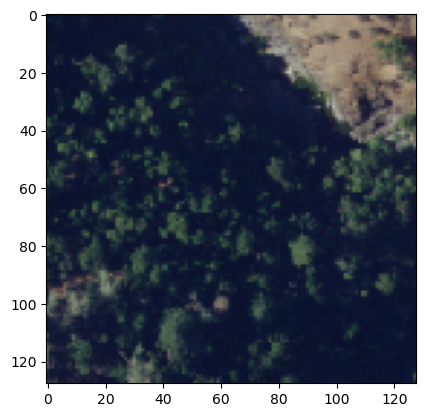

In [5]:
img = segmented_naip_images_tif[200]
print(img.max(),img.min())
print(img.dtype)
print(img.shape)
plt.imshow(img)

(128, 128)
[0 1 2 3]
3 0
uint8


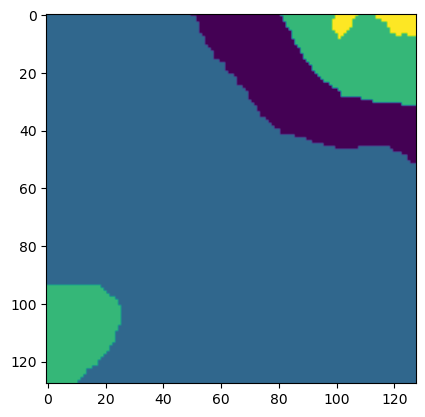

In [6]:
lbl = segmented_naip_new_labels[200]
print(lbl.shape)
print(np.unique(lbl))
print(lbl.max(),lbl.min())
print(lbl.dtype)
plt.imshow(lbl)

In [7]:
train_images, test_images, train_labels, test_labels = train_test_split(segmented_naip_images_tif, segmented_naip_new_labels, test_size=.25, shuffle=True)
print(train_images.shape,train_labels.shape)

(8928, 128, 128, 3) (8928, 128, 128)


In [8]:
del segmented_naip_images_tif
del segmented_naip_new_labels
print(train_labels.dtype)
print(train_images.dtype)

uint8
float32


In [12]:
#All my callback are called here
r_lr = hp.reduce_lr()
e_stop = hp.early_stop()
save = hp.save_check()
callbacks = [r_lr,e_stop,save]
gc.collect()

1383

In [16]:
keras.backend.clear_session()
model = hp.build_unet_model()
model.summary()
gc.collect()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 128, 128, 32  155        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 128, 128, 32  1344       ['separable_conv2d[0][0]']       
 onv2D)                         )                                                             

2541

In [17]:
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks = callbacks)

Epoch 1/50
279/279 [==============================] - 45s 151ms/step - loss: 0.8913 - accuracy: 0.6372 - mean_io_u: 0.4445 - val_loss: 1.8744 - val_accuracy: 0.6205 - val_mean_io_u: 0.3900 - lr: 0.0100
Epoch 2/50
279/279 [==============================] - 41s 147ms/step - loss: 0.7794 - accuracy: 0.6847 - mean_io_u: 0.5053 - val_loss: 1.7901 - val_accuracy: 0.5166 - val_mean_io_u: 0.3136 - lr: 0.0100
Epoch 3/50
279/279 [==============================] - 41s 145ms/step - loss: 0.7465 - accuracy: 0.6979 - mean_io_u: 0.5223 - val_loss: 1.7105 - val_accuracy: 0.5499 - val_mean_io_u: 0.3404 - lr: 0.0100
Epoch 4/50
279/279 [==============================] - 41s 145ms/step - loss: 0.7184 - accuracy: 0.7111 - mean_io_u: 0.5378 - val_loss: 1.4964 - val_accuracy: 0.6114 - val_mean_io_u: 0.4006 - lr: 0.0100
Epoch 5/50
279/279 [==============================] - 41s 146ms/step - loss: 0.7053 - accuracy: 0.7160 - mean_io_u: 0.5446 - val_loss: 3.1723 - val_accuracy: 0.4426 - val_mean_io_u: 0.2159 - l

In [18]:
model.save('simple_seg_model_softmax.h5')

1/1 [==============================] - 1s 916ms/step


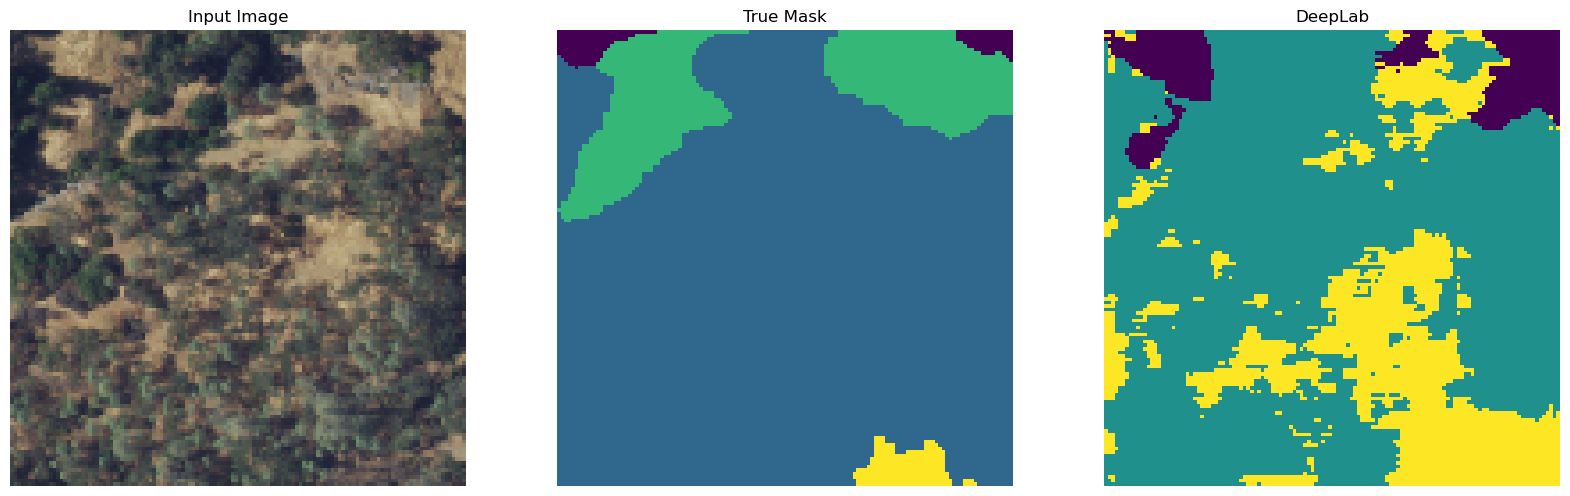

1/1 [==============================] - 0s 17ms/step


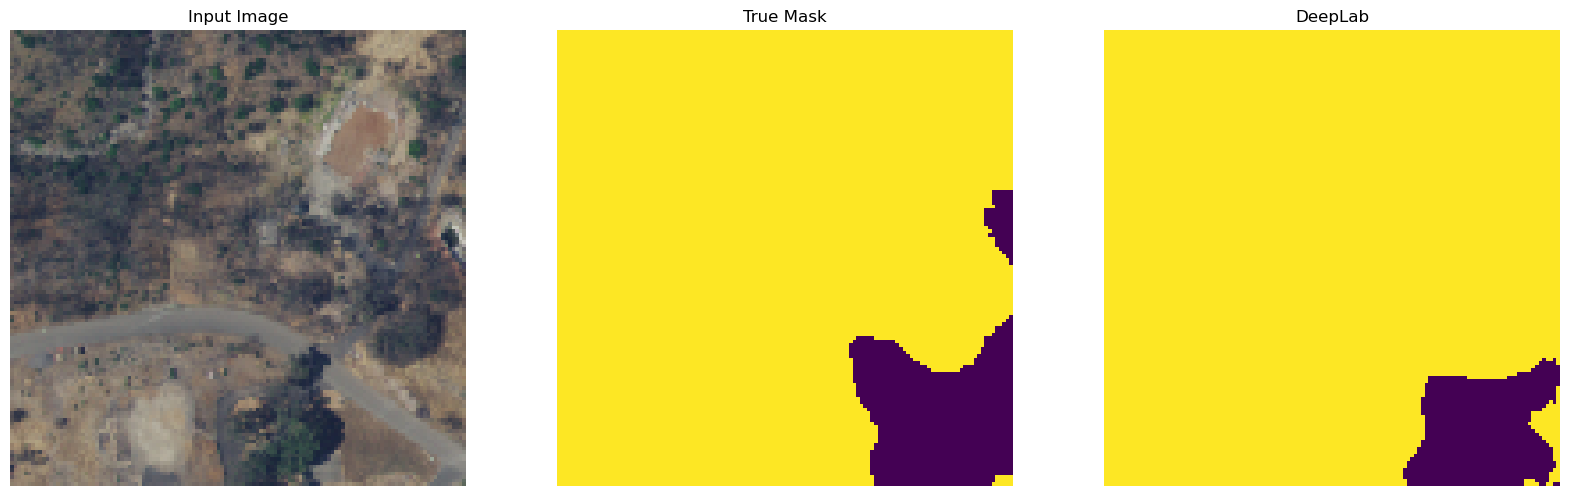

1/1 [==============================] - 0s 16ms/step


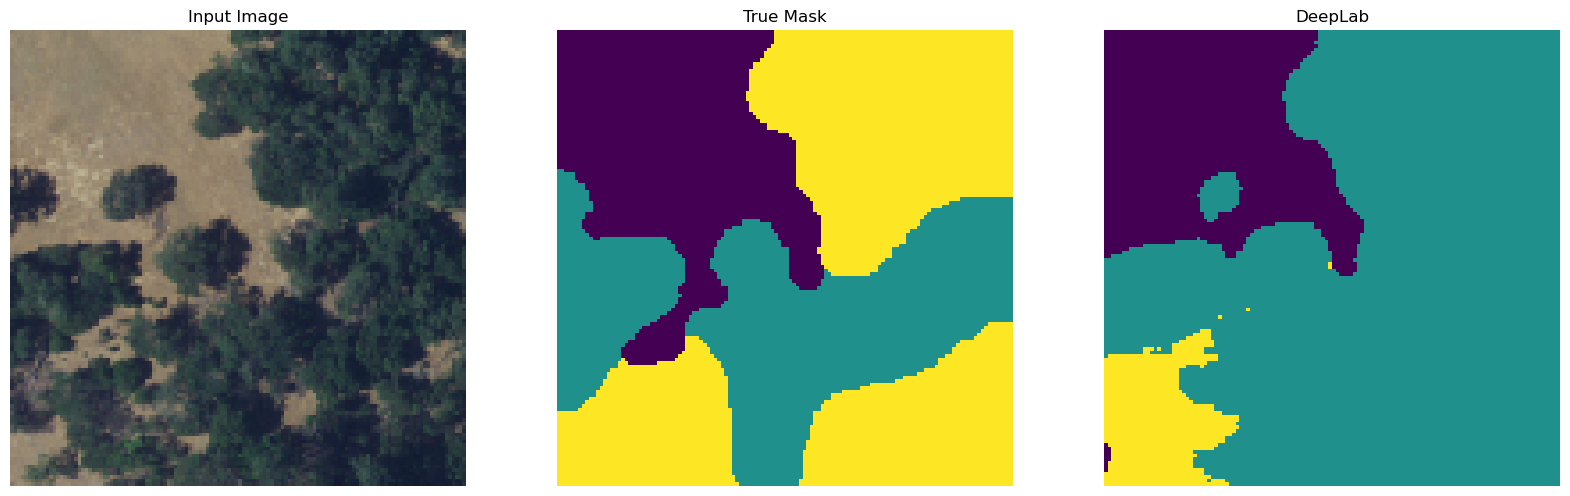

In [19]:
hp.show_predictions(model,test_images[10:13],test_labels[10:13], 3)

In [20]:
keras.backend.clear_session()
model_mobile = hp.mobile_unet_model(output_channels=4)
gc.collect()

39240

In [21]:
gc.collect()

473

In [22]:
model_history_mobile = model_mobile.fit(train_images, train_labels, epochs=50,batch_size=6,
                          validation_data=(test_images, test_labels),
                          callbacks=callbacks)

Epoch 1/50
1488/1488 [==============================] - 38s 24ms/step - loss: 0.9226 - accuracy: 0.6262 - mean_io_u: 0.4325 - val_loss: 0.7943 - val_accuracy: 0.6764 - val_mean_io_u: 0.4718 - lr: 0.0100
Epoch 2/50
1488/1488 [==============================] - 35s 24ms/step - loss: 0.8533 - accuracy: 0.6548 - mean_io_u: 0.4668 - val_loss: 0.9554 - val_accuracy: 0.6257 - val_mean_io_u: 0.4478 - lr: 0.0100
Epoch 3/50
1488/1488 [==============================] - 36s 24ms/step - loss: 0.8263 - accuracy: 0.6678 - mean_io_u: 0.4819 - val_loss: 0.7719 - val_accuracy: 0.6856 - val_mean_io_u: 0.5093 - lr: 0.0100
Epoch 4/50
1488/1488 [==============================] - 36s 24ms/step - loss: 0.8029 - accuracy: 0.6766 - mean_io_u: 0.4930 - val_loss: 0.7853 - val_accuracy: 0.6742 - val_mean_io_u: 0.4969 - lr: 0.0100
Epoch 5/50
1488/1488 [==============================] - 35s 24ms/step - loss: 0.7866 - accuracy: 0.6835 - mean_io_u: 0.5018 - val_loss: 0.7303 - val_accuracy: 0.7104 - val_mean_io_u: 0.546

1/1 [==============================] - 1s 1s/step


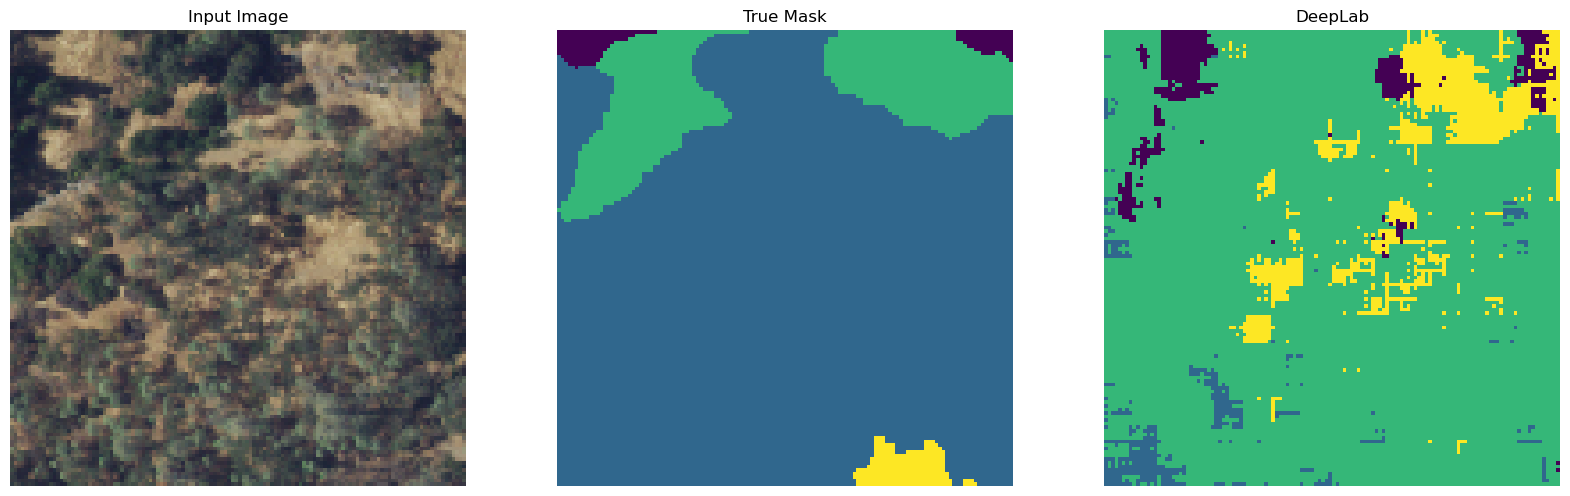

1/1 [==============================] - 0s 16ms/step


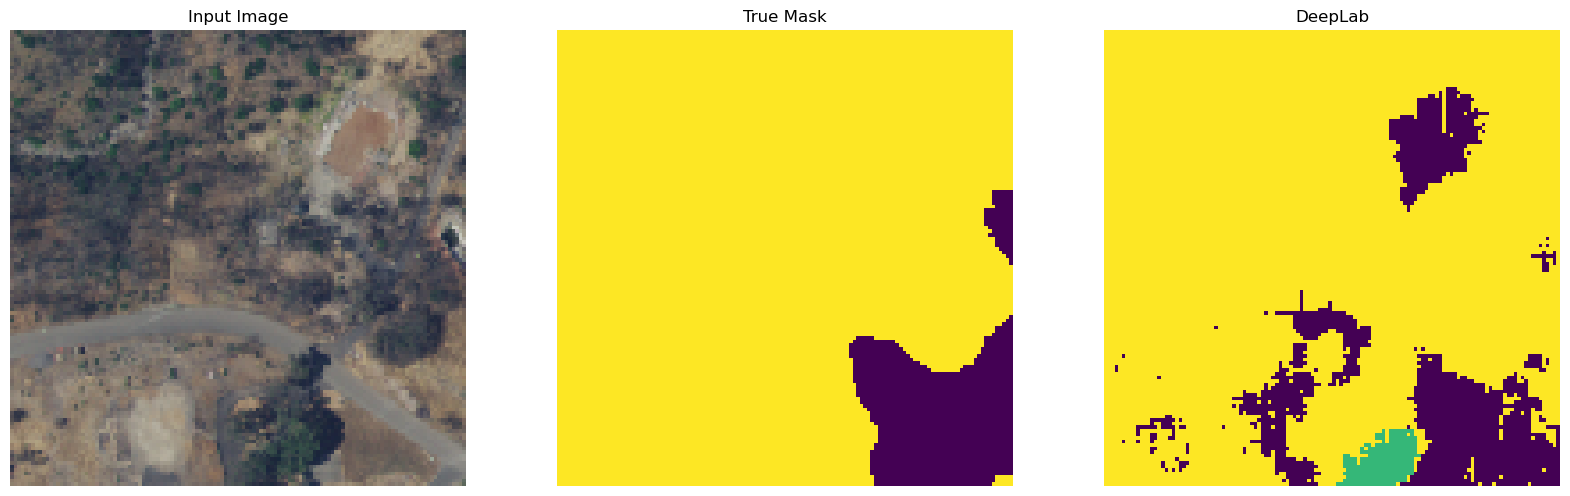

1/1 [==============================] - 0s 17ms/step


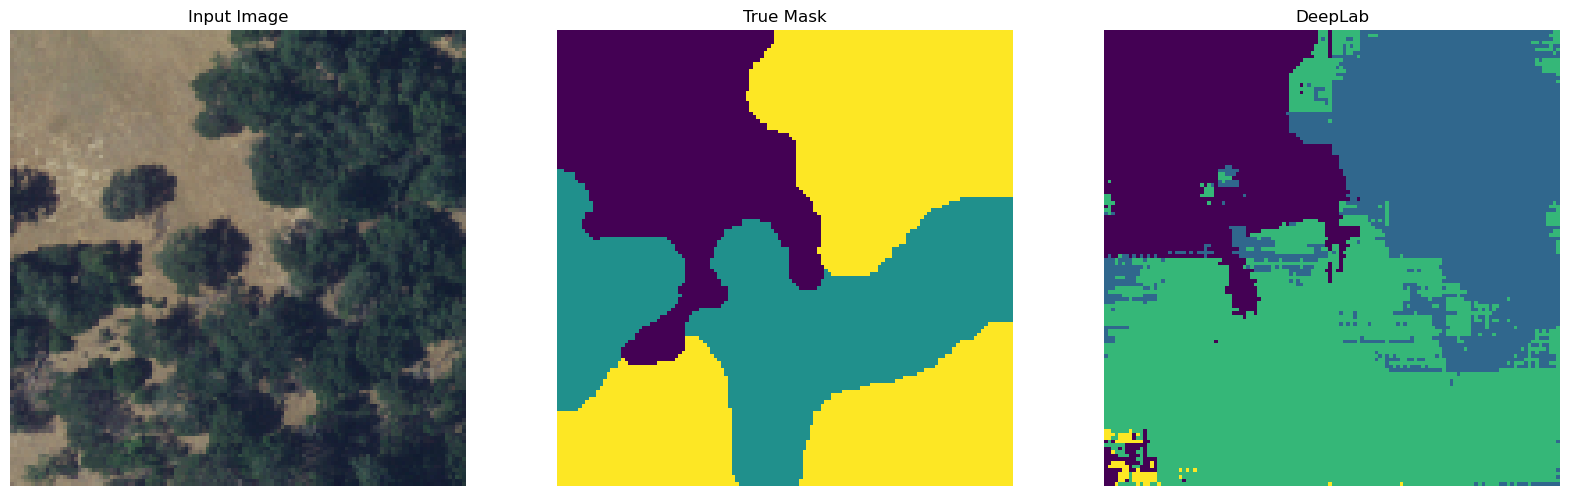

In [23]:
hp.show_predictions(model_mobile,test_images[10:13],test_labels[10:13], 3)

In [24]:
model_mobile.save('mobilenet_seg_model_softmax.h5', overwrite=True)

In [34]:
keras.backend.clear_session()
model_deeplab = hp.DeeplabV3Plus(image_size=128, num_classes=4)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 128, 128, 32  155        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 128, 128, 32  1344       ['separable_conv2d[0][0]']       
 onv2D)                         )                                                             

In [58]:
gc.collect()


473

In [30]:
model_history = model_deeplab.fit(train_images, train_labels, epochs=50,batch_size=6,
                          validation_data=(test_images, test_labels),
                          callbacks=callbacks)

Epoch 1/50
1488/1488 [==============================] - 62s 40ms/step - loss: 0.9663 - accuracy: 0.6139 - mean_io_u: 0.4126 - val_loss: 0.9541 - val_accuracy: 0.6006 - val_mean_io_u: 0.3858 - lr: 0.0100
Epoch 2/50
1488/1488 [==============================] - 57s 38ms/step - loss: 0.8380 - accuracy: 0.6623 - mean_io_u: 0.4765 - val_loss: 1.0382 - val_accuracy: 0.6252 - val_mean_io_u: 0.4370 - lr: 0.0100
Epoch 3/50
1488/1488 [==============================] - 57s 39ms/step - loss: 0.8242 - accuracy: 0.6661 - mean_io_u: 0.4813 - val_loss: 0.8312 - val_accuracy: 0.6602 - val_mean_io_u: 0.4742 - lr: 0.0100
Epoch 4/50
1488/1488 [==============================] - 57s 38ms/step - loss: 0.7840 - accuracy: 0.6826 - mean_io_u: 0.5018 - val_loss: 1.0197 - val_accuracy: 0.5674 - val_mean_io_u: 0.3791 - lr: 0.0100
Epoch 5/50
1488/1488 [==============================] - 58s 39ms/step - loss: 0.7519 - accuracy: 0.6959 - mean_io_u: 0.5182 - val_loss: 3.5822 - val_accuracy: 0.3946 - val_mean_io_u: 0.184

In [ ]:
hp.show_predictions(model_deeplab,test_images[10:13],test_labels[10:13], 3)

In [31]:
model_deeplab.save('deeplabv3_seg_model_softmax.h5')

In [42]:
test_images.shape

(2977, 128, 128, 3)

In [54]:
hp.voting(['deeplabv3_seg_model_softmax.h5','mobilenet_seg_model_softmax.h5', 'simple_seg_model_softmax.h5' ],test_images[0:2000],test_labels[0:2000],offset =225)

deeplabv3_seg_model_softmax.h5
0.6082115
mobilenet_seg_model_softmax.h5
0.5479749
simple_seg_model_softmax.h5
0.61901706


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
hp.voting(['deeplabv3_seg_model_full.h5','mobilenet_seg_model_full.tf', 'simple_seg_model_full.h5' ],test_images[0:2000],test_labels[0:2000],offset =225)

deeplabv3_seg_model_full.h5
0.6310945
mobilenet_seg_model_softmax.h5
0.5479749
simple_seg_model_softmax.h5
0.61901706
s_voting
0.63206255
h_voting
0.5766902


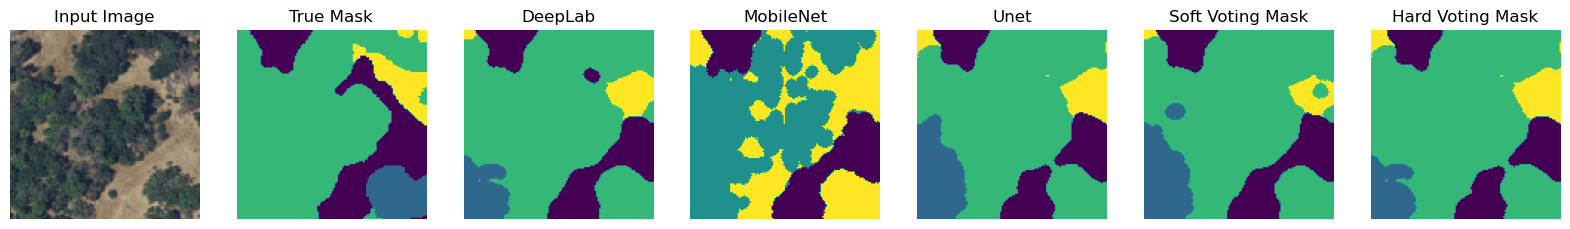

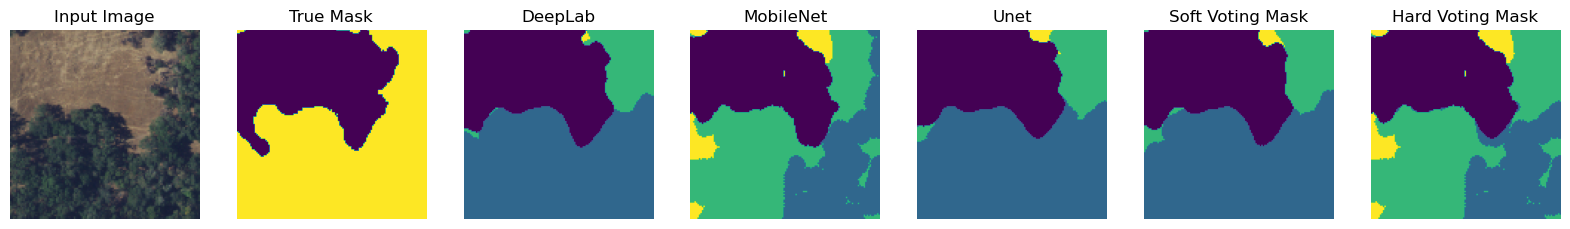

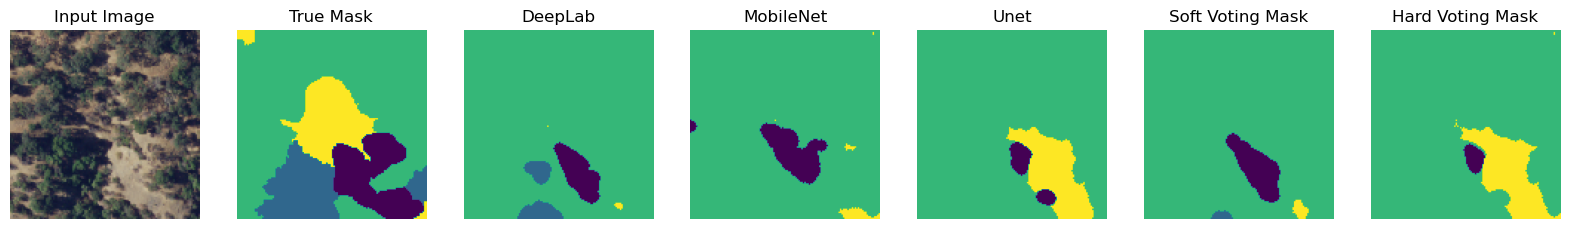

In [56]:
hp.voting(['deeplabv3_seg_model_full.h5','mobilenet_seg_model_softmax.h5', 'simple_seg_model_softmax.h5' ],test_images[0:2000],test_labels[0:2000],offset =225)